## env : Kaggle Notebook
## ref : https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [1]:
# Error - wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)


In [2]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

print(f'original - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf')
print(f'present  - np : {np.__version__}  |  pd : {pd.__version__}  |  mpl : {mpl.__version__}  |  sklearn : {sklearn.__version__}  |  tf : {tf.__version__}  |  hub : {hub.__version__}  |  keras : {keras.__version__}')

original - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf
present  - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf


In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## **1. Keyword and Location**

### **1.1 Missing Values**
Both training and test set have same ratio of missing values in `keyword` and `location`.
* **0.8%** of `keyword` is missing in both training and test set
* **33%** of `location` is missing in both training and test set

Since missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

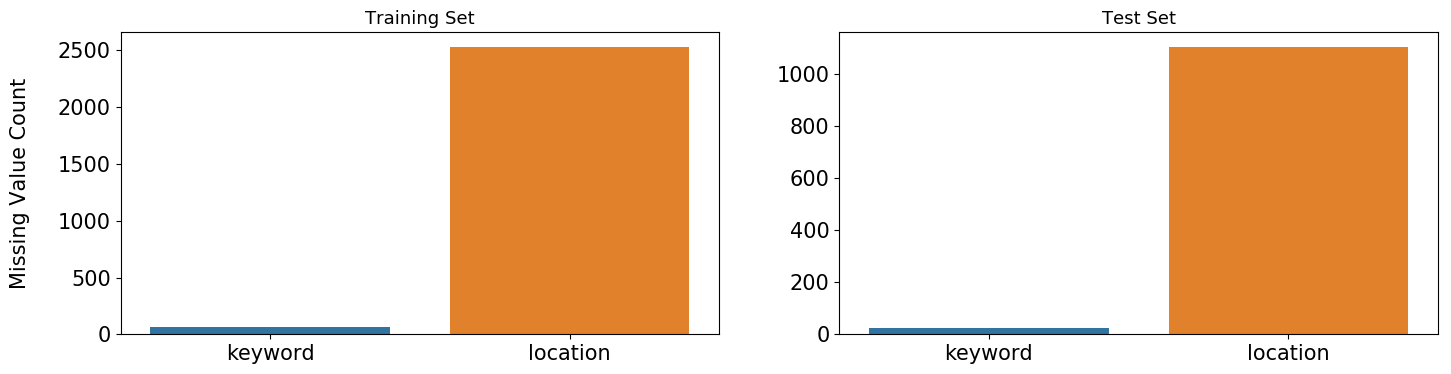

>>> Missing Value Change (train, test) : (2594, 1131) -> (0, 0)


In [4]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(1, 2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[['keyword', 'location']].isna().sum().index, y=df_train[['keyword', 'location']].isna().sum(), ax=axes[0])
sns.barplot(x=df_test[['keyword', 'location']].isna().sum().index,  y=df_test[['keyword', 'location']].isna().sum(),  ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].set_title('Training Set', size=13)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].set_title('Test Set', size=13)

plt.show()

print(f'>>> Missing Value Change (train, test) : ({df_train[missing_cols].isna().sum().sum()}, {df_test[missing_cols].isna().sum().sum()})', end=' -> ')
for df in [df_train, df_test]:
    for col in missing_cols:
        df[col] = df[col].fillna(f'no_{col}')
print(f'({df_train[missing_cols].isna().sum().sum()}, {df_test[missing_cols].isna().sum().sum()})')